In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# Input data files are available in the "../input/" directory.
# Any results you write to the current directory are saved as output.
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [4]:
# Imports

import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMAGE_SIZE = [180, 180]
EPOCHS = 25

In [9]:
# Input loading

# labels = ['PNEUMONIA', 'NORMAL']
# img_size = 150
# def get_training_data(data_dir):
#    data = [] 
#    for label in labels: 
#        path = os.path.join(data_dir, label)
#        class_num = labels.index(label)
#        for img in os.listdir(path):
#            try:
#                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
#                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
#                data.append([resized_arr, class_num])
#            except Exception as e:
#                print(e)
#    return np.array(data, dtype=object)

#train = get_training_data('../chest_xray/train')
#test = get_training_data('../chest_xray/test')
#val = get_training_data('../chest_xray/val')

In [7]:
filenames = tf.io.gfile.glob(str('../chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str('../chest_xray/val/*/*')))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

In [8]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1078
Pneumonia images count in training set: 3107


In [9]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

for f in train_list_ds.take(5):
    print(f.numpy())

b'../chest_xray/train/PNEUMONIA/person544_virus_1080.jpeg'
b'../chest_xray/train/PNEUMONIA/person833_virus_1469.jpeg'
b'../chest_xray/train/PNEUMONIA/person1608_bacteria_4235.jpeg'
b'../chest_xray/train/PNEUMONIA/person21_bacteria_72.jpeg'
b'../chest_xray/train/PNEUMONIA/person1454_bacteria_3780.jpeg'


2022-11-21 17:25:35.746250: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [11]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str("../chest_xray/train/*"))])
CLASS_NAMES

array(['PNEUMONIA', 'NORMAL'], dtype='<U9')

In [15]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == "PNEUMONIA"

In [12]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)

In [13]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [16]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [17]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [18]:
test_list_ds = tf.data.Dataset.list_files(str('../chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

TEST_IMAGE_COUNT

624

In [27]:
image_batch, label_batch = next(iter(train_ds))

In [28]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

IndexError: invalid index to scalar variable.

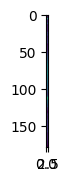

In [29]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [24]:
# Distribution plot in train set

l = []
for i in train_ds:
    image_batch, label_batch = i
    print("Label: ", label_batch)
    if(label_batch == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
        
sns.histplot(l)

Label:  tf.Tensor(True, shape=(), dtype=bool)


TypeError: Cannot convert 0 to EagerTensor of dtype bool

Text(0.5, 1.0, 'NORMAL')

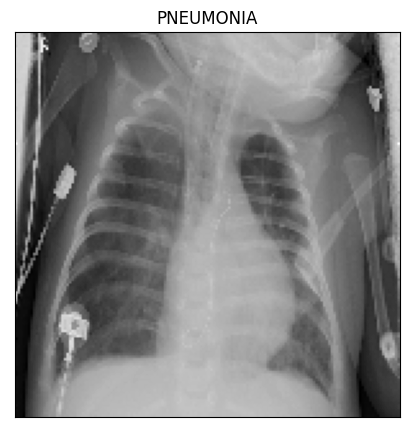

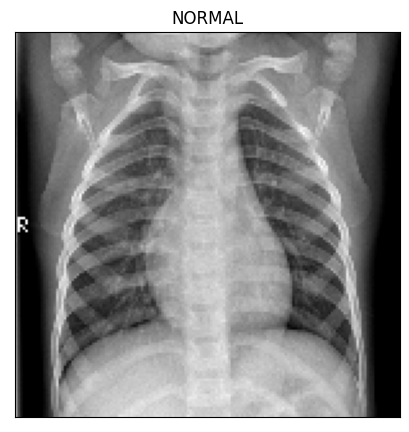

In [11]:
# Examples

plt.figure(figsize = (5,5))
plt.xticks([])
plt.yticks([])
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.xticks([])
plt.yticks([])
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [12]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [13]:
# Normalize the data

x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [14]:
# Resize data for deep learning 

x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [15]:
# Data Augmentation
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [16]:
# Training the Model

model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

2022-11-19 18:47:07.179467: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 38, 38, 64)        36928     
                                                                 
 batch_normalization_2 (Batc  (None, 38, 38, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 19, 19, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 19, 19, 128)       73856     
                                                                 
 dropout_1

In [17]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [18]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 161s 976ms/step - loss: 0.5725 - accuracy: 0.8363 - val_loss: 28.6461 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
163/163 [==============================] - 170s 1s/step - loss: 0.3147 - accuracy: 0.8873 - val_loss: 63.6529 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.2640 - accuracy: 0.9091
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 168s 1s/step - loss: 0.2640 - accuracy: 0.9091 - val_loss: 19.9618 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/12
163/163 [==============================] - 176s 1s/step - loss: 0.1743 - accuracy: 0.9419 - val_loss: 12.3443 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/12
163/163 [==============================] - 174s 1s/step - loss: 0.1378 - accuracy: 0.9492 - val_loss: 1.7102 - val_accuracy: 0.6250 - lr: 3.0000e-04
Epoch 6/12
163/163 [========================

In [19]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 6s 280ms/step - loss: 0.3679 - accuracy: 0.9022
Loss of the model is -  0.3679228127002716
20/20 [==============================] - 5s 271ms/step - loss: 0.3679 - accuracy: 0.9022
Accuracy of the model is -  90.22436141967773 %


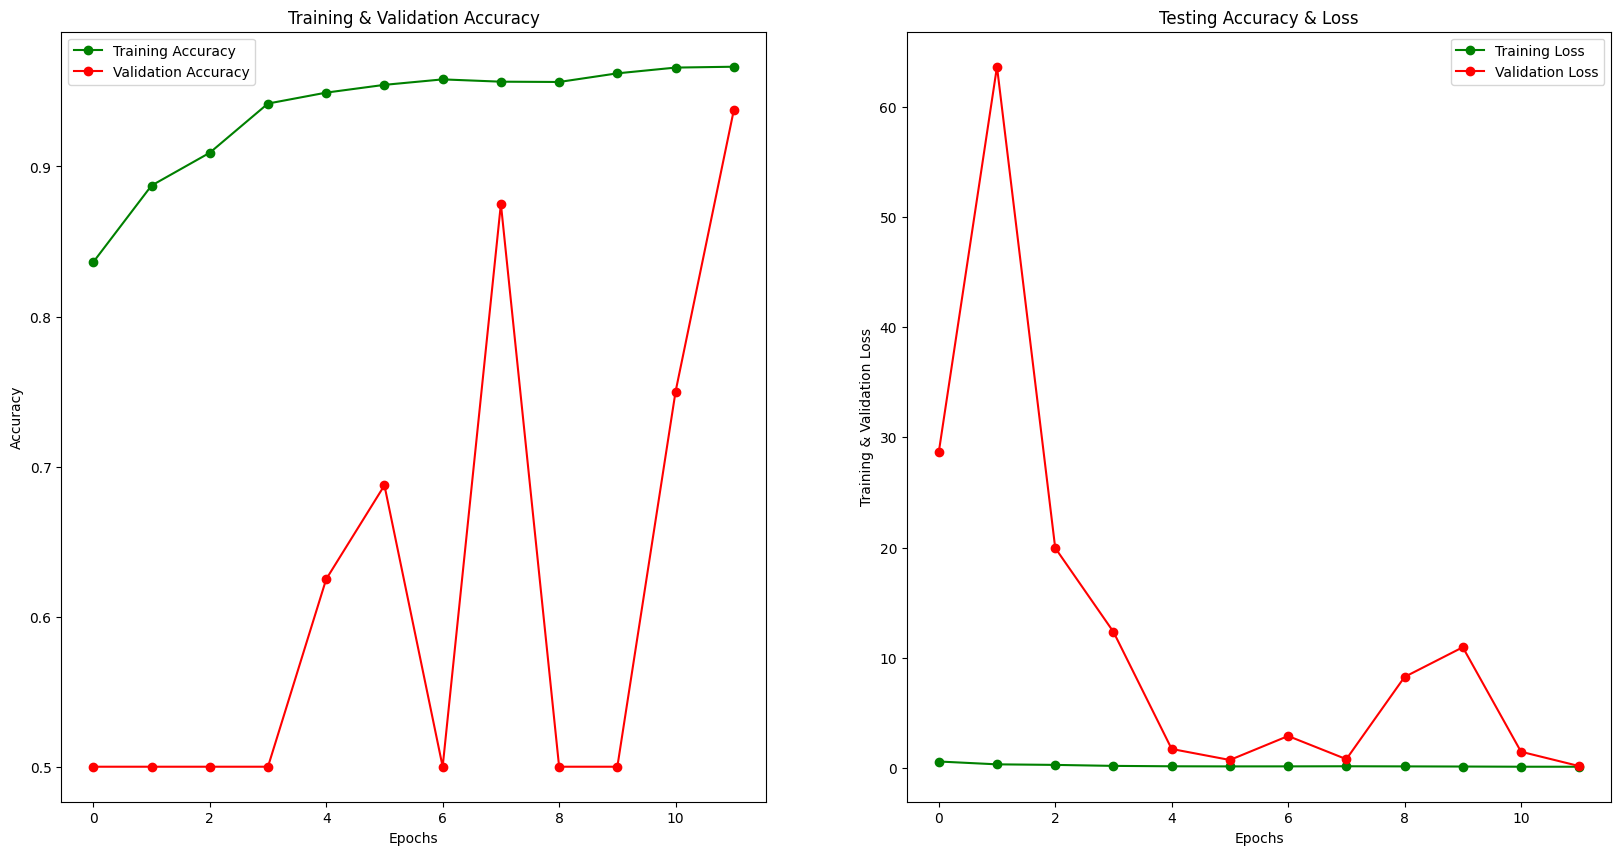

In [20]:
# Analysis after Model Training

epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [21]:
# Predictions

predictions = (model.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

20/20 [==============================] - 6s 284ms/step


array([0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [22]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.93      0.91      0.92       390
   Normal (Class 1)       0.86      0.88      0.87       234

           accuracy                           0.90       624
          macro avg       0.89      0.90      0.90       624
       weighted avg       0.90      0.90      0.90       624



In [23]:
cm = confusion_matrix(y_test,predictions)
cm

array([[356,  34],
       [ 27, 207]])

In [24]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<AxesSubplot: >

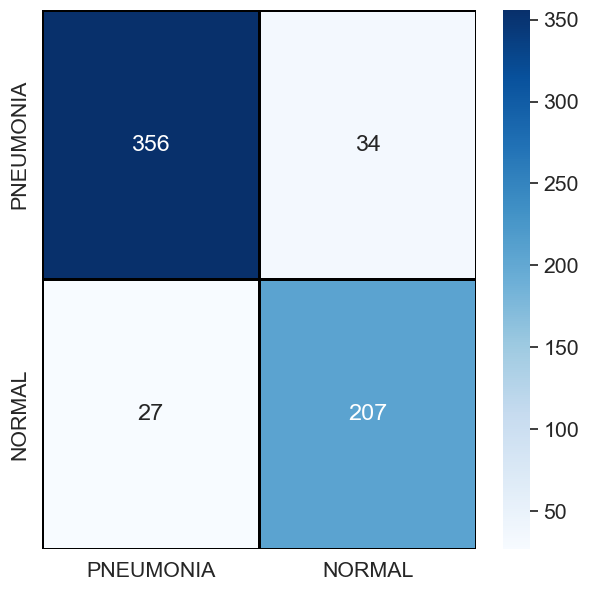

In [25]:
plt.figure(figsize = (7,7))
sns.set(font_scale=1.4)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black', linewidth = 1, annot = True, fmt='', xticklabels = labels, yticklabels = labels)

In [26]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

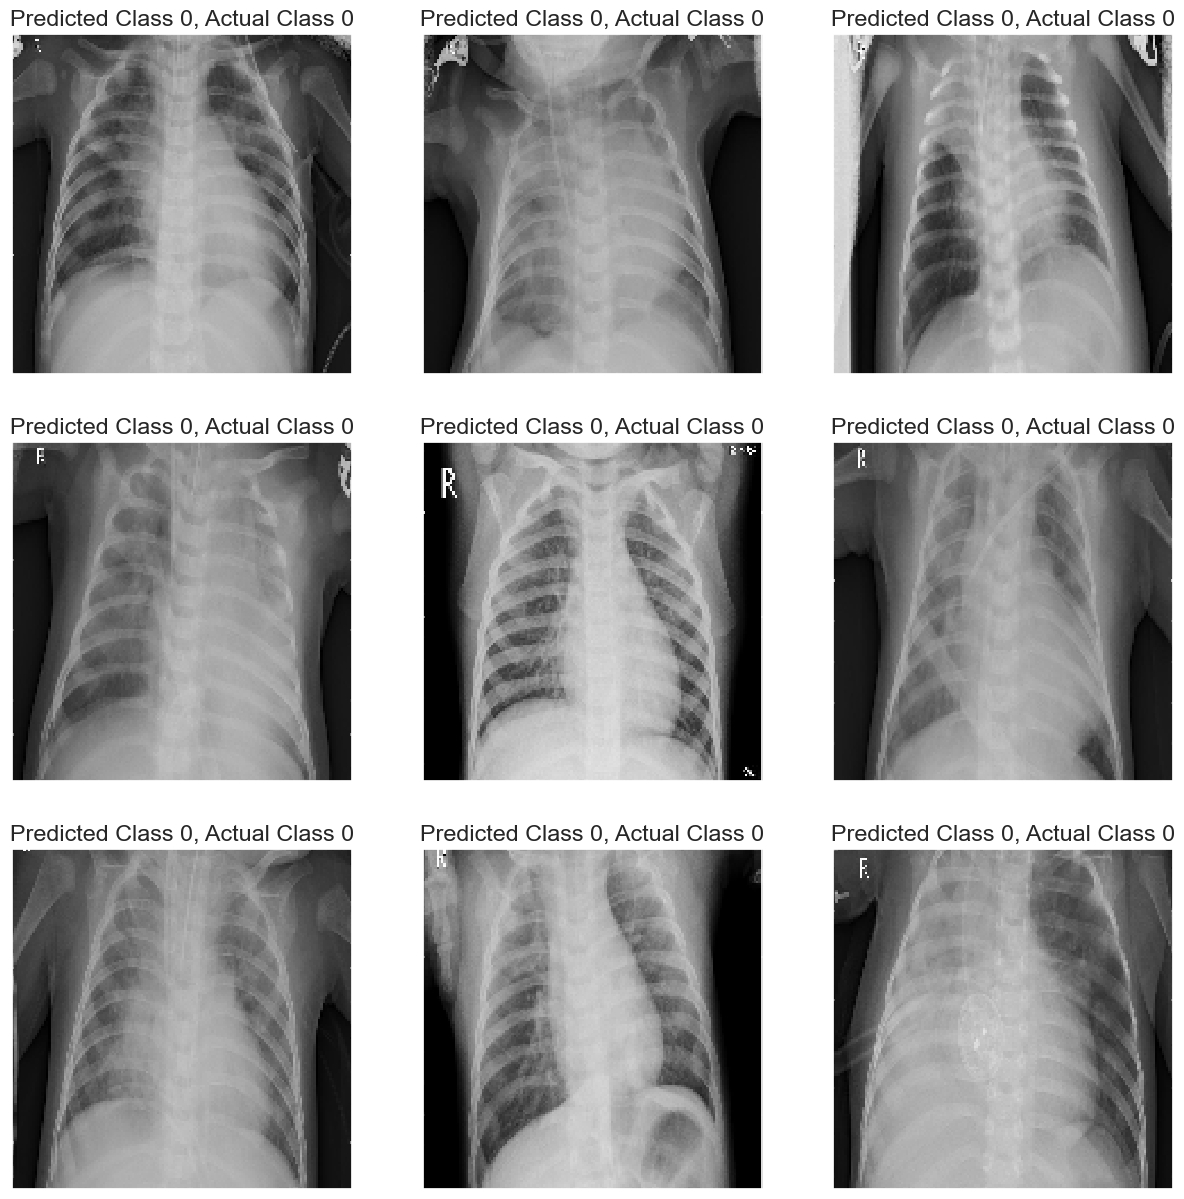

In [27]:
# Some of the Correctly Predicted Classes

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i in range(3):
    for j in range(3):
        axs[i, j].set_yticks([])
        axs[i, j].set_xticks([])
        axs[i, j].imshow(x_test[correct[3*i+j]].reshape(150,150), cmap="gray", interpolation='none')
        axs[i, j].set_title("Predicted Class {}, Actual Class {}".format(predictions[correct[3*i+j]], y_test[correct[3*i+j]]))

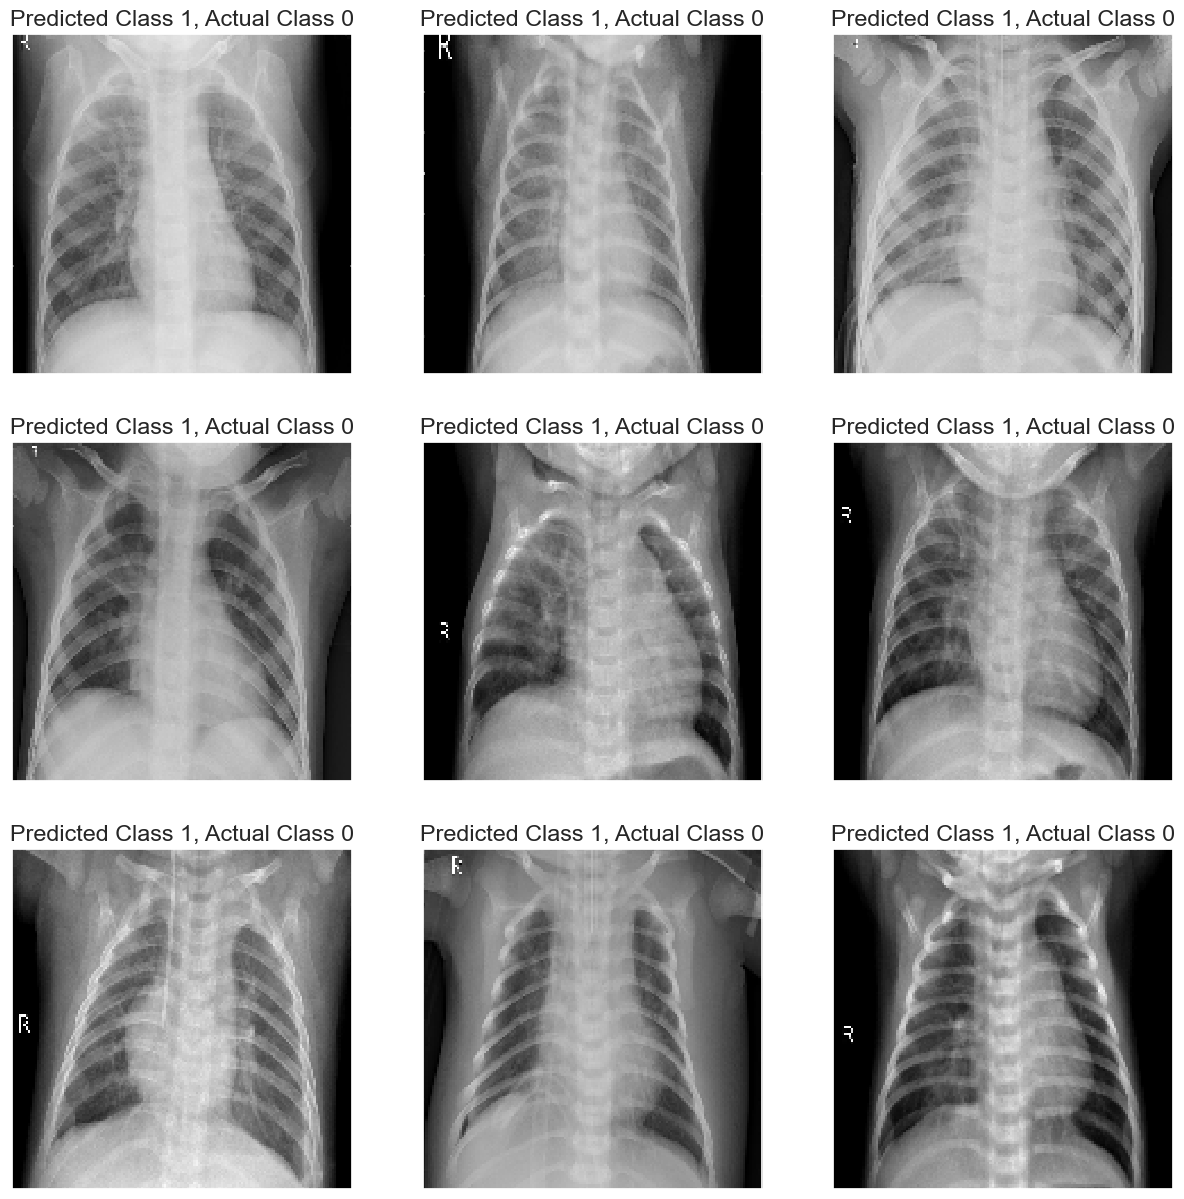

In [28]:
# Some of the Incorrectly Predicted Classes

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i in range(3):
    for j in range(3):
        axs[i, j].set_yticks([])
        axs[i, j].set_xticks([])
        axs[i, j].imshow(x_test[incorrect[3*i+j]].reshape(150,150), cmap="gray", interpolation='none')
        axs[i, j].set_title("Predicted Class {}, Actual Class {}".format(predictions[incorrect[3*i+j]], y_test[incorrect[3*i+j]]))

NameError: name 'test_ds' is not defined